# **ЛР №4**: Формирование данных для машинного обучения в формате NumPy на основе датасета Semantic3D

## **Ход работы**

Начало обраюотки датасета S3DIS

Обработка папки: /home/kklub/cvcourse/CVin3D9/lab6/Stanford3dDataset_v1.2/Area_5/office_3/Annotations
  Обработка файла: clutter_14.txt -> класс: clutter (ID: 12)
  Обработка файла: clutter_8.txt -> класс: clutter (ID: 12)
  Обработка файла: clutter_7.txt -> класс: clutter (ID: 12)
  Обработка файла: window_1.txt -> класс: window (ID: 5)
  Обработка файла: clutter_15.txt -> класс: clutter (ID: 12)
  Обработка файла: wall_2.txt -> класс: wall (ID: 2)
  Обработка файла: chair_3.txt -> класс: chair (ID: 7)
  Обработка файла: floor_1.txt -> класс: floor (ID: 1)
  Обработка файла: clutter_5.txt -> класс: clutter (ID: 12)
  Обработка файла: bookcase_2.txt -> класс: bookcase (ID: 9)
  Обработка файла: bookcase_3.txt -> класс: bookcase (ID: 9)
  Обработка файла: chair_1.txt -> класс: chair (ID: 7)
  Обработка файла: table_2.txt -> класс: table (ID: 8)
  Обработка файла: clutter_12.txt -> класс: clutter (ID: 12)
  Обработка файла: ceiling_1.txt -> класс: ceiling

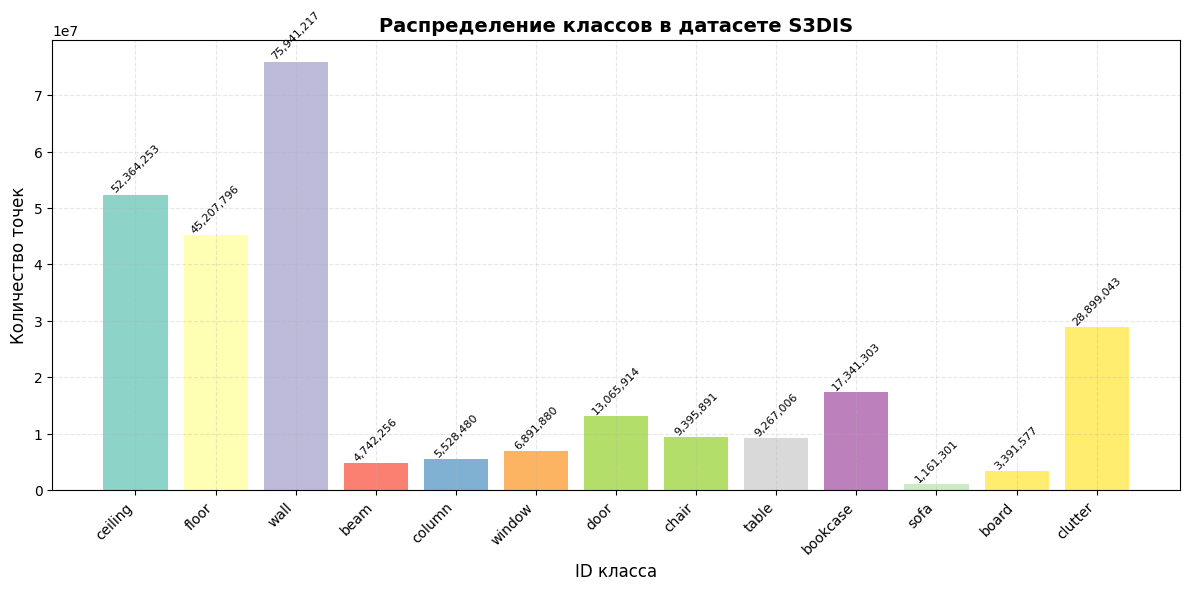

Обработка завершена.


In [3]:
import h5py
import matplotlib.pyplot as plt
import os
import numpy as np

CLASS_MAPPING = {
    "ceiling": 0,
    "floor": 1,
    "wall": 2,
    "beam": 3,
    "column": 4,
    "window": 5,
    "door": 6,
    "chair": 7,
    "table": 8,
    "bookcase": 9,
    "sofa": 10,
    "board": 11,
    "clutter": 12,
}

REVERSE_CLASS_MAPPING = {cls_id: cls_name for cls_name, cls_id in CLASS_MAPPING.items()}


def process_s3dis_annotations(data_root_path: str):
    
    point_cloud_segments = []
    label_segments = []
    clutter_id = CLASS_MAPPING["clutter"]

    for current_path, subdirs, files in os.walk(data_root_path):
        current_folder = os.path.basename(current_path)
        
        if current_folder != "Annotations":
            continue
            
        print(f"\nОбработка папки: {current_path}")
        
        for filename in files:
            if not filename.endswith(".txt"):
                continue
                
            full_path = os.path.join(current_path, filename)
            object_class = filename.split("_")[0]
            
            class_id = CLASS_MAPPING.get(object_class, clutter_id)
            print(f"  Обработка файла: {filename} -> класс: {object_class} (ID: {class_id})")
            
            try:
                point_data = np.loadtxt(full_path)
            except Exception as e:
                print(f"    Ошибка загрузки {filename}: {e}")
                continue
                
            if point_data.ndim != 2 or point_data.shape[1] != 6:
                print(f"    Пропущен файл {filename}: неверное количество столбцов ({point_data.shape[1] if point_data.ndim == 2 else 'не 2D'})")
                continue
                
            coordinates = point_data[:, :3].astype(np.float32)
            rgb_values = point_data[:, 3:6].astype(np.float32)
            
            normalized_colors = rgb_values / 255.0
            np.clip(normalized_colors, 0.0, 1.0, out=normalized_colors)
            
            point_count = coordinates.shape[0]
            float_labels = np.full((point_count, 1), class_id, dtype=np.float32)
            int_labels = np.full(point_count, class_id, dtype=np.int32)
            
            segment_data = np.column_stack((
                coordinates,
                normalized_colors,
                float_labels
            )).astype(np.float32)
            
            point_cloud_segments.append(segment_data)
            label_segments.append(int_labels)

    if not point_cloud_segments:
        raise ValueError(f"Не найдено корректных файлов аннотаций в: {data_root_path}")
        
    combined_data = np.vstack(point_cloud_segments)
    combined_labels = np.concatenate(label_segments)
    
    print(f"\nОбъединено {len(point_cloud_segments)} сегментов")
    print(f"Общий размер данных перед нормализацией: {combined_data.shape}")
    
    xyz_coords = combined_data[:, :3]
    centroid = xyz_coords.mean(axis=0)
    scale = xyz_coords.std(axis=0)
    scale[scale == 0] = 1.0
    
    normalized_coords = (xyz_coords - centroid) / scale
    combined_data[:, :3] = normalized_coords
    
    print(f"Нормализация завершена. Центр: {centroid}, Масштаб: {scale}")
    print(f"Финальный размер датасета: {combined_data.shape}")
    
    return combined_data.astype(np.float32), combined_labels.astype(np.int32)


def export_dataset(data_array: np.ndarray, label_array: np.ndarray, output_format: str, output_prefix: str = "processed_s3dis"):
    
    print(f"\nЭкспорт датасета в формат: {output_format}")
    output_format = output_format.lstrip('.')
    
    if output_format in ['npy', 'numpy']:
        np.save(f"{output_prefix}.npy", data_array)
        print(f"Сохранено: {output_prefix}.npy")
    
    elif output_format in ['txt', 'text']:
        np.savetxt(f"{output_prefix}.txt", data_array, fmt='%.6f', delimiter=' ')
        print(f"Сохранено: {output_prefix}.txt")
    
    elif output_format in ['h5', 'hdf5', 'hdf']:
        with h5py.File(f"{output_prefix}.h5", 'w') as hdf_file:
            hdf_file.create_dataset('point_cloud_data', data=data_array, compression='gzip')
            hdf_file.create_dataset('class_labels', data=label_array, compression='gzip')
        print(f"Сохранено: {output_prefix}.h5")
    
    else:
        raise ValueError(f"Неподдерживаемый формат: {output_format}. Используйте npy, txt или h5.")


def visualize_class_distribution(label_data: np.ndarray, class_mapping_dict: dict = None):
    
    unique_classes, class_counts = np.unique(label_data, return_counts=True)
    
    plt.figure(figsize=(12, 6), dpi=100)
    bars = plt.bar(range(len(unique_classes)), class_counts, 
                  color=plt.cm.Set3(np.linspace(0, 1, len(unique_classes))))
    
    plt.title('Распределение классов в датасете S3DIS', fontsize=14, fontweight='bold')
    plt.xlabel('ID класса', fontsize=12)
    plt.ylabel('Количество точек', fontsize=12)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    if class_mapping_dict:
        class_names = [class_mapping_dict.get(int(cls_id), f'ID_{int(cls_id)}') 
                      for cls_id in unique_classes]
        plt.xticks(range(len(unique_classes)), class_names, rotation=45, ha='right')
    else:
        plt.xticks(range(len(unique_classes)), [str(int(x)) for x in unique_classes])
    
    for idx, (bar, count) in enumerate(zip(bars, class_counts)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                f'{count:,}', ha='center', va='bottom', fontsize=8, rotation=45)
    
    plt.tight_layout()
    plt.savefig('class_distribution.png', bbox_inches='tight', dpi=150)
    print("График распределения классов сохранен как 'class_distribution.png'")
    
    plt.show()


if __name__ == "__main__":
    DATASET_ROOT = "/home/kklub/cvcourse/CVin3D9/lab6/Stanford3dDataset_v1.2"
    
    print("Начало обраюотки датасета S3DIS")
    
    processed_data, class_labels = process_s3dis_annotations(DATASET_ROOT)
    
    print(f"\nРезультаты предобработки:")

    print(f"Форма финального датасета: {processed_data.shape}")
    print(f"Тип данных: {processed_data.dtype}")
    print("\nПервые 3 строки данных:")
    print("-" * 50)
    for i in range(3):
        print(f"Строка {i+1}: {processed_data[i]}")
    print("-" * 50)
    
    export_dataset(processed_data, class_labels, "npy", "semantic3d_dataset")
    
    print("Распределение классов:")

    visualize_class_distribution(class_labels, REVERSE_CLASS_MAPPING)
    
    print("Обработка завершена.")


## Ответы на контрольные вопросы

**Общие вопросы по датасету S3DIS:**

1. **Что такое S3DIS и для чего он используется?**  
S3DIS (Stanford 3D Indoor Spaces) — это датасет 3D-сканирований интерьеров. Используется для семантической сегментации облаков точек и распознавания объектов в помещениях.

2. **Какие типы данных содержит S3DIS?**  
Содержит 3D-координаты точек (X, Y, Z), цветовые значения (R, G, B) и семантические метки классов.

3. **Сколько пространств (Areas) включает датасет?**  
6 пространств (Areas 1-6).

4. **Что представляют собой строки в .txt файлах S3DIS? Опишите формат.**  
Каждая строка — одна точка. Формат: X Y Z R G B, где X,Y,Z — координаты, R,G,B — цвета в диапазоне [0,255].

5. **Какие задачи машинного обучения можно решать с помощью S3DIS?**  
Семантическая сегментация 3D-сцен, классификация объектов, распознавание помещений.

6. **Какие классы (объекты) включены в разметку S3DIS? Приведите примеры.**  
ceiling, floor, wall, beam, column, window, door, chair, table, bookcase, sofa, board, clutter.

**Вопросы по подготовке данных:**

7. **Какие признаки можно извлекать из данных S3DIS для обучения моделей?**  
3D-координаты (X,Y,Z), цвета (R,G,B), а также производные признаки: нормали поверхностей, геометрические особенности.

8. **Что такое нормализация координат, и зачем она нужна при подготовке 3D данных?**  
Нормализация — центрирование и масштабирование координат. Нужна для улучшения сходимости ML-моделей и устранения влияния разных масштабов.

9. **Почему важно сохранять данные в формате NumPy (.npy, .npz) при работе с ML-моделями?**  
Формат NumPy обеспечивает быструю загрузку/сохранение, сохраняет форму и тип данных, совместим с ML-фреймворками.

10. **Как разделить данные на входные признаки и метки классов?**  
Признаки: dataset[:, :6] (X,Y,Z,R,G,B), метки: dataset[:, 6] (label).

11. **Чем отличается np.save() от np.savez() и np.savez_compressed()?**  
np.save() — один массив в .npy; np.savez() — несколько массивов в несжатый .npz; np.savez_compressed() — несколько массивов в сжатый .npz.

12. **Какие потенциальные проблемы могут возникнуть при чтении и обработке S3DIS?**  
Большие размеры файлов, нехватка памяти, дисбаланс классов, поврежденные файлы, шум в сканах.